# DAPI binding to DNA -3: Steady-state fluorescence spectroscopy 

Let's begin loading necessary python modules and data we collect in lab.


Downloads:
- Data [available here](https://scarsi.web.cern.ch/MISC/LBP/steadyStateSpect/Data.rar) (place the folder `Data` near this notebook)
- This executable jupyter notebook [available here](https://scarsi.web.cern.ch/MISC/LBP/steadyStateSpect/steadyStateSpect.ipynb)


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import os

In [2]:
lstData = []
lstSol = []

dataToSkip = ("Sol2_sameSET_lamp75W.txt", "Sol3_sameSET_lamp75W.txt", "Sol4_sameSET_lamp75W.txt")

for e in os.scandir(r"./data"):
    #print(e.name)
    if e.name in dataToSkip: continue
    if e.name[0] != "S": continue
    
    tmpData = np.loadtxt(e, skiprows = 4, unpack = False)
    
    # We put a 0.3 OD filter 
    if "od" in e.name:
        tmpData[:,1] = 2*tmpData[:,1]
    
    lstData.append(tmpData[:,:2].copy())
    lstSol.append(e.name.split("_")[0][3:])
    
lstData = np.array(lstData)
lstSol = np.array(lstSol, dtype = int)
print(lstSol)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


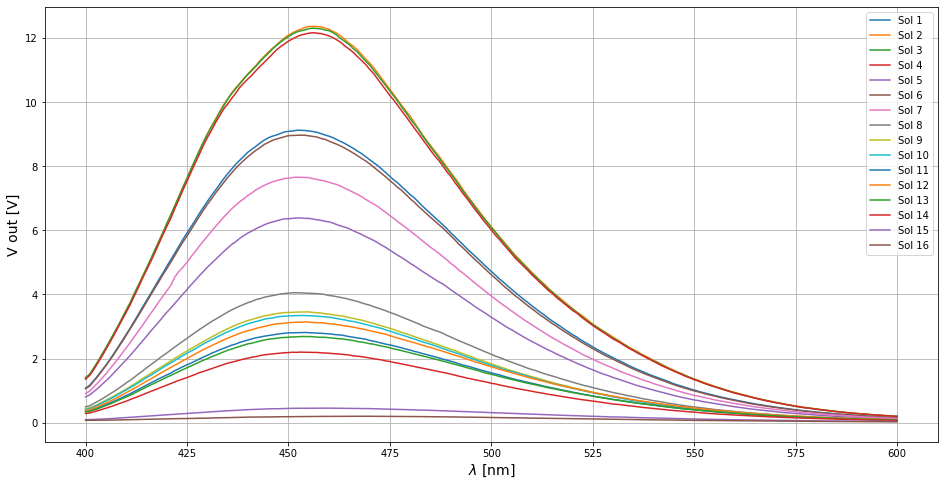

In [3]:
vectMassimi = []

fig, ax = plt.subplots()
fig.set_size_inches(16,8)


for i,j in zip(lstData, lstSol):
    ax.plot(i[:,0], i[:,1], label = f"Sol {j}")
    vectMassimi.append(np.max(i[:,1]))
    
   
ax.set_xlabel("$\lambda$ [nm]", fontsize = 14)
ax.set_ylabel("V out [V]", fontsize = 14)

    
ax.legend()
ax.grid(True)
    
plt.show()

vectMassimi = np.array(vectMassimi)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


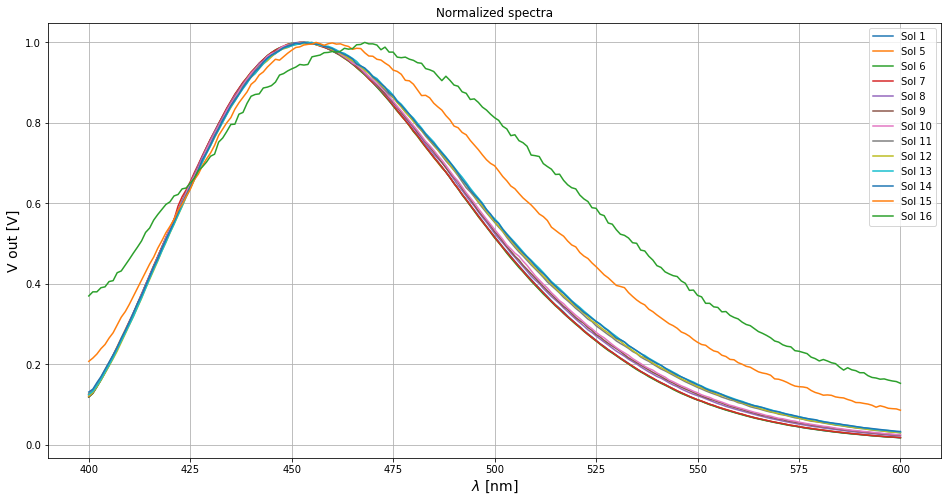

In [4]:
# Stesso plot di sopra, ma normalizzati al massimo

%matplotlib inline



fig, ax = plt.subplots()
fig.set_size_inches(16,8)

idx = 0
for i,j in zip(lstData, lstSol):
    print(idx)
    if (idx>=1) & (idx<=3): 
        idx +=1
        continue
    ax.plot(i[:,0], i[:,1]/np.max(i[:,1]), label = f"Sol {j}")
    idx +=1
   
ax.set_xlabel("$\lambda$ [nm]", fontsize = 14)
ax.set_ylabel("V out [V]", fontsize = 14)
ax.set_title("Normalized spectra")
    
ax.legend()
ax.grid(True)
    
plt.show()



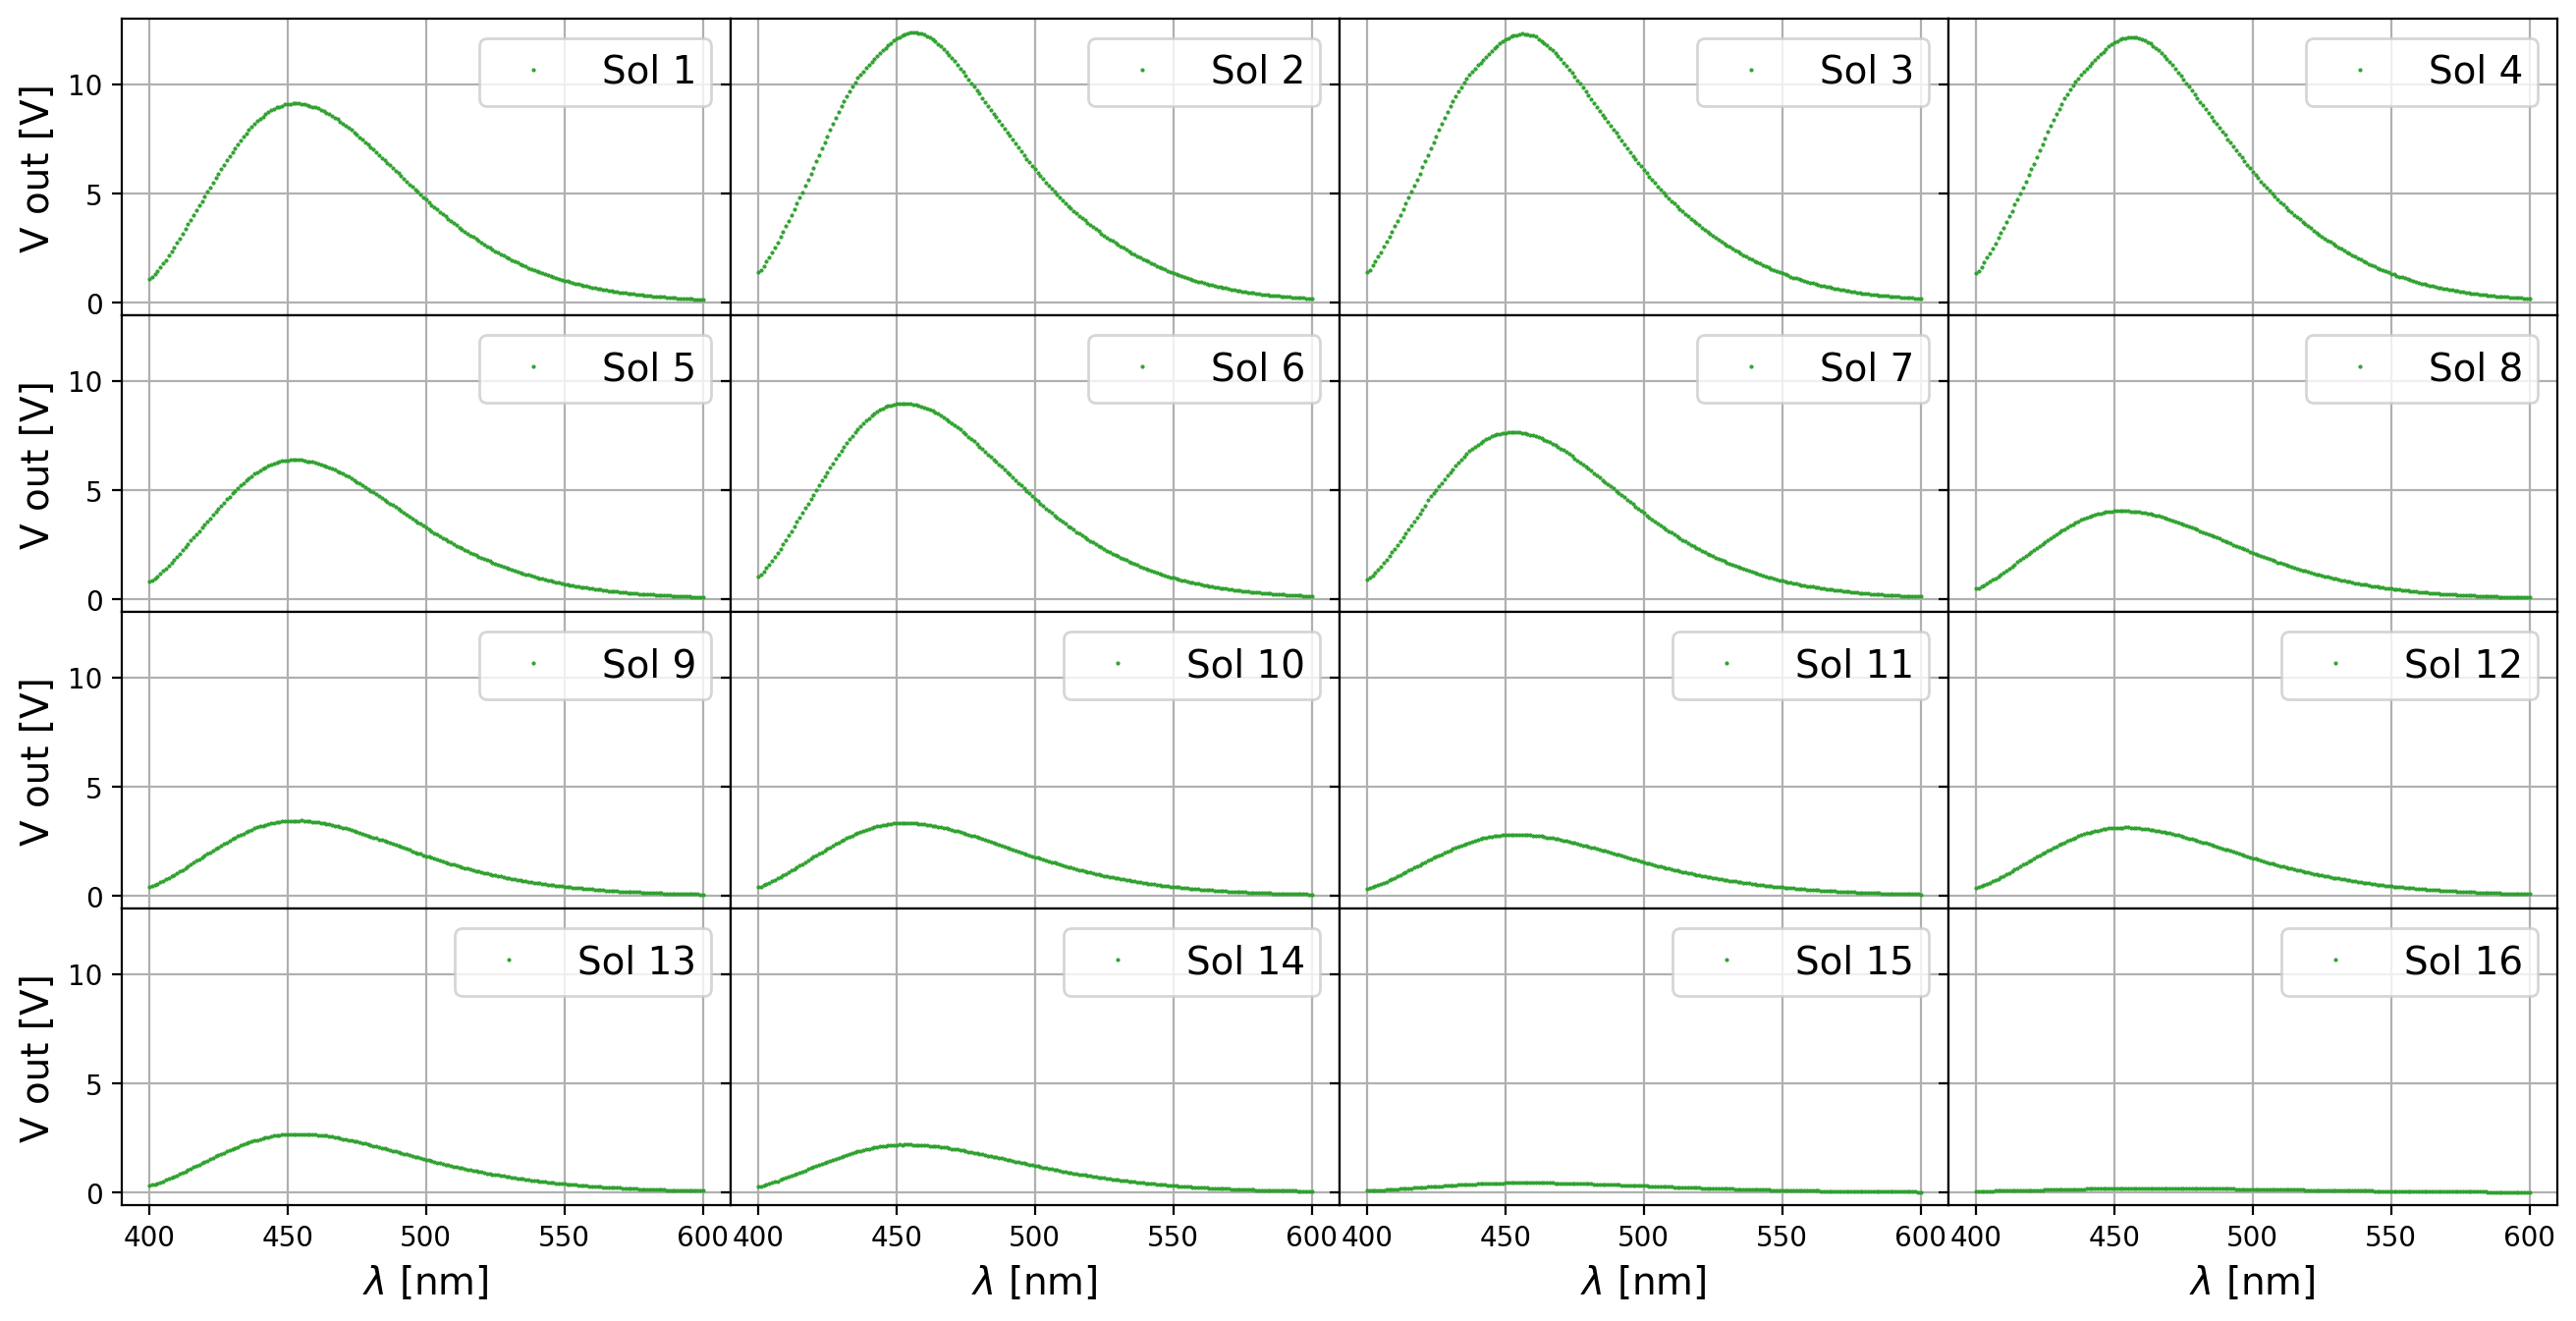

In [5]:
fig, ax = plt.subplots(4,4, dpi = 200, sharey = True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace = 0, hspace = 0)
axx = ax.flatten()

for i, j in enumerate(lstData):
    ax = axx[i]
    ax.plot(j[:,0], j[:,1], ls = "", marker = ".", ms = 1, label = f"Sol {lstSol[i]}", c = "tab:green")

    if i>11:
        ax.set_xlabel("$\lambda$ [nm]", fontsize = 14)
    if i%4 == 0:
        ax.set_ylabel("V out [V]", fontsize = 14)

    ax.legend(fontsize = 14)
    ax.grid(True)
    
plt.show()

# Plot of peak vs DNA concentration

Now i plot the peak for each spectrum and the Vout at sol1's peak  vs the concentration of DNA, both on linear and logx scale (be careful, point at 0 is not present in log plot).

Sol2,3 and 4 are acquired with a filter of 3 optical density

In [6]:
# Concentrazione microMolare [uM]
concDNA = np.array((0, 10, 20, 40,
                    50, 60, 80, 90,
                    100, 200, 400, 600,
                    700, 800, 900, 1000))[::-1]

# soluzione 1 = più concentrat
# soluzione 16 = meno concentrata

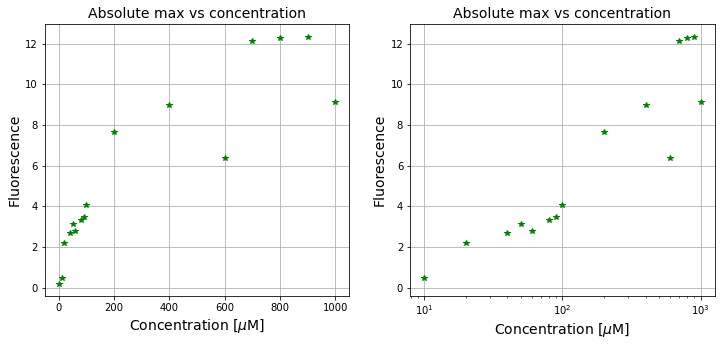

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

#ax.plot(np.array(listaCol2), vectLambda, "*g")

for a in ax:
    a.plot(concDNA, vectMassimi, "*g")

    a.set_title("Absolute max vs concentration", fontsize = 14)
    a.set_xlabel("Concentration [$\mu$M]", fontsize = 14)
    a.set_ylabel("Fluorescence", fontsize = 14)

    a.grid()
ax[1].set_xscale("log")

plt.show()

In [8]:
set1 = lstData[0][:,1]
tmpIdx = np.argmax(set1)
vectAbsorbFix = np.array([i[tmpIdx,1] for i in lstData])
vectAbsorbFix

array([ 9.11762 , 12.26432 , 12.21668 , 12.08436 ,  6.3851  ,  8.96563 ,
        7.65124 ,  4.04951 ,  3.45011 ,  3.34399 ,  2.81089 ,  3.13205 ,
        2.68761 ,  2.20173 ,  0.452659,  0.190995])

In [9]:
print(f" Chosen λ: {lstData[0][tmpIdx,0]} nm")

 Chosen λ: 453.0 nm


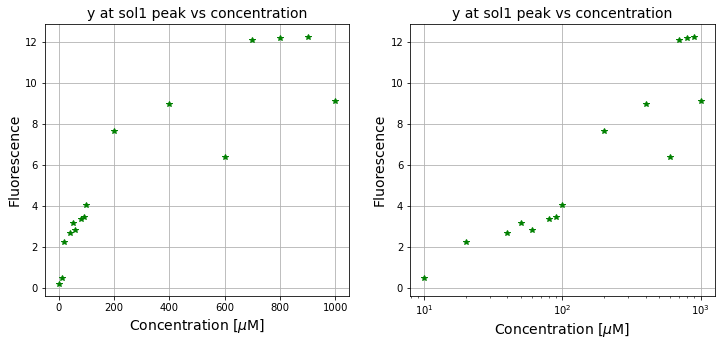

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

#ax.plot(np.array(listaCol2), vectLambda, "*g")

for a in ax:
    a.plot(concDNA, vectAbsorbFix, "*g")

    a.set_title("y at sol1 peak vs concentration", fontsize = 14)
    a.set_xlabel("Concentration [$\mu$M]", fontsize = 14)
    a.set_ylabel("Fluorescence", fontsize = 14)

    a.grid()
ax[1].set_xscale("log")

plt.show()

[ True False False False False  True  True  True  True  True  True  True
  True  True  True  True]


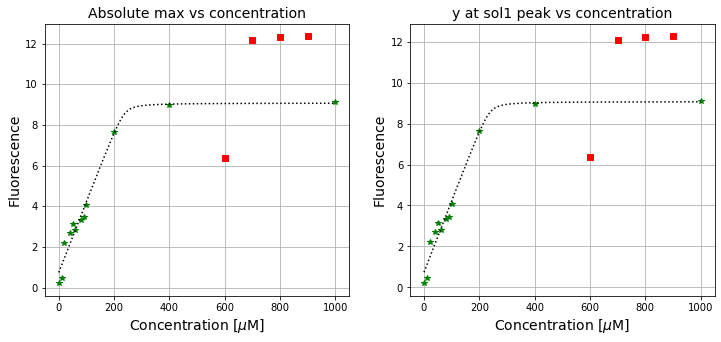

[0.09313316 1.04153068 0.03373396 0.03659616] [0.09241937 1.04228166 0.03373712 0.03688993]


In [11]:

D = 8 # 8uM
def funToFit(Cdna, I0, DI, n, Kdiss):
    return I0*D + DI * .5 * (n*Cdna + D + Kdiss - np.sqrt((n*Cdna + D + Kdiss)**2 - 4*n*D*Cdna))


# Outline to manually exclude
cond = (concDNA == 900) | (concDNA == 800) | (concDNA == 700) | (concDNA == 600) 
cond = ~cond
print(cond)
popt0, pcov0 = curve_fit(funToFit, concDNA[cond], vectMassimi[cond], maxfev = 1000000, 
                         p0 = [0.09313351, 1.04152937, 0.03373389, 0.03658978])
popt1, pcov1 = curve_fit(funToFit, concDNA[cond], vectAbsorbFix[cond], maxfev = 1000000, 
                         p0 = [0.09241895, 1.04228331, 0.03373719, 0.03689794])


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

#ax.plot(np.array(listaCol2), vectLambda, "*g")
xDenso = np.linspace(concDNA.min(), concDNA.max(), 1000)

ax[0].plot(concDNA[cond], vectMassimi[cond], "*g")
ax[0].plot(concDNA[~cond], vectMassimi[~cond], "sr")
ax[0].set_title("Absolute max vs concentration", fontsize = 14)
ax[0].set_xlabel("Concentration [$\mu$M]", fontsize = 14)
ax[0].set_ylabel("Fluorescence", fontsize = 14)
ax[0].plot(xDenso, funToFit(xDenso, *popt0), ":k")

ax[1].plot(concDNA[cond], vectAbsorbFix[cond], "*g")
ax[1].plot(concDNA[~cond], vectAbsorbFix[~cond], "sr")
ax[1].set_title("y at sol1 peak vs concentration", fontsize = 14)
ax[1].set_xlabel("Concentration [$\mu$M]", fontsize = 14)
ax[1].set_ylabel("Fluorescence", fontsize = 14)
ax[1].plot(xDenso, funToFit(xDenso, *popt1), ":k")


for a in ax:
    a.grid()

plt.show()

print(popt0, popt1)

In [12]:
print("Abs max")
print(f"I0 = {popt0[0]:.4f}")
print(f"I0*D = {popt0[0]*D:.4f}") # Offset

print(f"Delta I = {popt0[1]:.4f}")
print(f"Delta I * D = {popt0[1]*D:.4f}") # Dynamic range

print(f"n = {popt0[2]:.4f}")
print(f"K diss = {popt0[3]:.4f}")
print(f"n/k = {popt0[2]/popt0[3]:.4f}")




print("\nL'altro")
print(f"I0 = {popt1[0]:.4f}")
print(f"I0*D = {popt1[0]*D:.4f}") # Offset

print(f"Delta I = {popt1[1]:.4f}")
print(f"Delta I * D = {popt1[1]*D:.4f}") # Dynamic range

print(f"n = {popt1[2]:.4f}")
print(f"K diss = {popt1[3]:.4f}")
print(f"n/k = {popt1[2]/popt1[3]:.4f}")

Abs max
I0 = 0.0931
I0*D = 0.7451
Delta I = 1.0415
Delta I * D = 8.3322
n = 0.0337
K diss = 0.0366
n/k = 0.9218

L'altro
I0 = 0.0924
I0*D = 0.7394
Delta I = 1.0423
Delta I * D = 8.3383
n = 0.0337
K diss = 0.0369
n/k = 0.9145


[ True False False False False  True  True  True  True  True  True  True
  True  True  True  True]


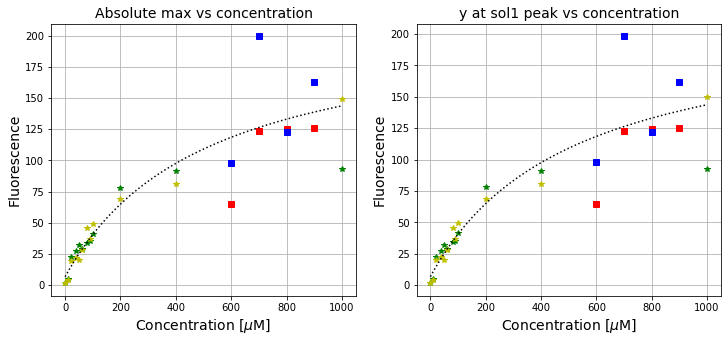

[8.53913925e-01 2.58573625e+01 3.28246703e+01 1.67934788e+04] [8.48289430e-01 2.58637227e+01 4.06992798e+01 2.08168462e+04]


In [13]:
%matplotlib inline

# Absorbance at 366
# Copied from other analysis
vectNewAbsorbance = np.array([0.142, 0.107, 0.112, 0.122, 0.156, 0.1  , 0.073, 0.093, 0.082,
       0.111, 0.111, 0.065, 0.061, 0.1  , 0.076, 0.061]) [::-1]

vectMassimiNorm = vectMassimi / vectNewAbsorbance
vectAbsorbFixNorm = vectAbsorbFix / vectNewAbsorbance


D = 8 # 8uM
def funToFit(Cdna, I0, DI, n, Kdiss):
    return I0*D + DI * .5 * (n*Cdna + D + Kdiss - np.sqrt((n*Cdna + D + Kdiss)**2 - 4*n*D*Cdna))


# Outline to manually exclude
cond = (concDNA == 900) | (concDNA == 800) | (concDNA == 700) | (concDNA == 600) 
cond = ~cond
print(cond)
popt0, pcov0 = curve_fit(funToFit, concDNA[cond], vectMassimiNorm[cond], maxfev = 1000000, 
                         p0 = [0.09313351, 1.04152937, 0.03373389, 0.03658978])
popt1, pcov1 = curve_fit(funToFit, concDNA[cond], vectAbsorbFixNorm[cond], maxfev = 1000000, 
                         p0 = [0.09241895, 1.04228331, 0.03373719, 0.03689794])


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

#ax.plot(np.array(listaCol2), vectLambda, "*g")
xDenso = np.linspace(concDNA.min(), concDNA.max(), 1000)

ax[0].plot(concDNA[cond], vectMassimi[cond]/vectNewAbsorbance.mean(), "*g")
ax[0].plot(concDNA[~cond], vectMassimi[~cond]/vectNewAbsorbance.mean(), "sr")
ax[0].plot(concDNA[cond], vectMassimiNorm[cond], "*y")
ax[0].plot(concDNA[~cond], vectMassimiNorm[~cond], "sb")

ax[0].set_title("Absolute max vs concentration", fontsize = 14)
ax[0].set_xlabel("Concentration [$\mu$M]", fontsize = 14)
ax[0].set_ylabel("Fluorescence", fontsize = 14)
ax[0].plot(xDenso, funToFit(xDenso, *popt0), ":k")

ax[1].plot(concDNA[cond], vectAbsorbFix[cond]/vectNewAbsorbance.mean(), "*g")
ax[1].plot(concDNA[~cond], vectAbsorbFix[~cond]/vectNewAbsorbance.mean(), "sr")
ax[1].plot(concDNA[cond], vectAbsorbFixNorm[cond], "*y")
ax[1].plot(concDNA[~cond], vectAbsorbFixNorm[~cond], "sb")

ax[1].set_title("y at sol1 peak vs concentration", fontsize = 14)
ax[1].set_xlabel("Concentration [$\mu$M]", fontsize = 14)
ax[1].set_ylabel("Fluorescence", fontsize = 14)
ax[1].plot(xDenso, funToFit(xDenso, *popt1), ":k")


for a in ax:
    a.grid()

plt.show()

print(popt0, popt1)

In [14]:
print("Abs max")
print(f"I0 = {popt0[0]:.4f}")
print(f"I0*D = {popt0[0]*D:.4f}") # Offset

print(f"Delta I = {popt0[1]:.4f}")
print(f"Delta I * D = {popt0[1]*D:.4f}") # Dynamic range

print(f"n = {popt0[2]:.4f}")
print(f"K diss = {popt0[3]:.4f}")
print(f"n/k = {popt0[2]/popt0[3]:.4f}")




print("\nL'altro")
print(f"I0 = {popt1[0]:.4f}")
print(f"I0*D = {popt1[0]*D:.4f}") # Offset

print(f"Delta I = {popt1[1]:.4f}")
print(f"Delta I * D = {popt1[1]*D:.4f}") # Dynamic range

print(f"n = {popt1[2]:.4f}")
print(f"K diss = {popt1[3]:.4f}")
print(f"n/k = {popt1[2]/popt1[3]:.4f}")

Abs max
I0 = 0.8539
I0*D = 6.8313
Delta I = 25.8574
Delta I * D = 206.8589
n = 32.8247
K diss = 16793.4788
n/k = 0.0020

L'altro
I0 = 0.8483
I0*D = 6.7863
Delta I = 25.8637
Delta I * D = 206.9098
n = 40.6993
K diss = 20816.8462
n/k = 0.0020


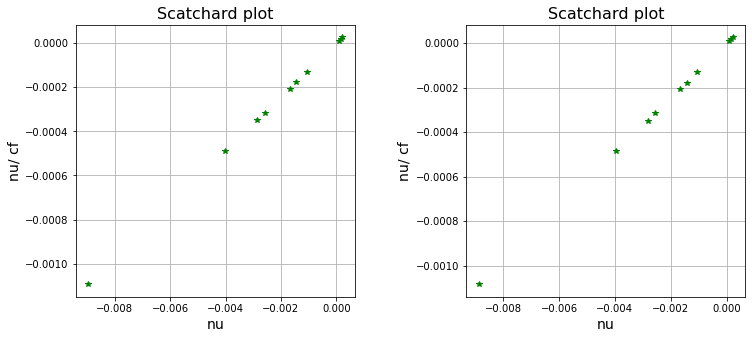

In [15]:
def myLine(x,m,q):
    return m*x+q

Cb_0 = (vectMassimi[cond] - popt0[0]*D ) / popt0[1]
Cb_0 = Cb_0[:-2]

Cb_1 = (vectAbsorbFix[cond] - popt1[0]*D ) / popt1[1]
Cb_1 = Cb_1[:-2]

# tmpLogic = (Cb >= 1) & (Cb < 7)

nu_0 = Cb_0 / concDNA[cond][:-2]
term2_0 = nu_0 / (D-Cb_0)
nu_1 = Cb_1 / concDNA[cond][:-2]
term2_1 = nu_1 / (D-Cb_1)

ccc0 = (term2_0 > -.05) & (term2_0 < .05)
ccc1 = (term2_1 > -.05) & (term2_1 < .05)

#popt, pcov = curve_fit(myLine, nu, term2)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.subplots_adjust(wspace = .4)
ax[0].plot(nu_0[ccc0], term2_0[ccc0], "*g")
ax[1].plot(nu_1[ccc1], term2_1[ccc1], "*g")

for a in ax:
    a.set_title("Scatchard plot", fontsize = 16)
    a.set_xlabel(f"nu", fontsize = 14)
    a.set_ylabel(f"nu/ cf", fontsize = 14)

    a.grid()
#ax.set_ylim((-.1, .2))

plt.show()